In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import time
import glob
import sys
import pickle
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, LogisticRegression

In [17]:
import itertools
from sklearn.model_selection import KFold

In [29]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters, calc_loadings
from loaders import load_sabes

In [19]:
with open('/mnt/Secondary/data/postprocessed/M1residual_decoding.pkl', 'rb') as f:
    df = pickle.load(f)
df = pd.DataFrame(df)

In [20]:
data_files = np.unique(df['data_file'])
dims = np.unique(df['dim'])
fold_idx = np.unique(df['fold_idx'])

In [21]:
r2 = np.zeros((len(data_files), dims.size, fold_idx.size, 2, 3))
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dims):
        for k, fold in enumerate(fold_idx):
            for h, dimreduc_method in enumerate(['PCA', 'LQGCA']):
                df_ = apply_df_filters(df, data_file=data_file, dim=dim, fold_idx=fold, dimreduc_method=dimreduc_method)
                assert(df_.shape[0] == 1)
                r2[i, j, k, h] = df_.iloc[0]['r2']

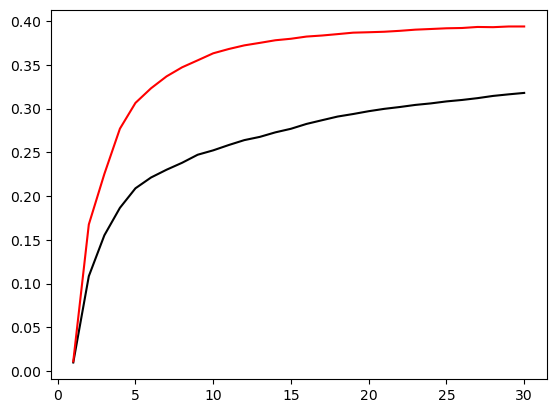

In [23]:
# Plotthe mean r2 averaged over the fold axis for both PCA and LQGCA:
r2_mean = np.mean(r2, axis=2)
r2_std = np.std(r2, axis=2)
fig, ax = plt.subplots()
ax.plot(dims, np.mean(r2_mean[:, :, 0, 1], axis=0), 'k')
ax.plot(dims, np.mean(r2_mean[:, :, 1, 1], axis=0), 'r')

In [24]:
# Now for S1
with open('/mnt/Secondary/data/postprocessed/S1residual_decoding.pkl', 'rb') as f:
    df = pickle.load(f)
df = pd.DataFrame(df)

In [25]:
data_files = np.unique(df['data_file'])
dims = np.unique(df['dim'])
fold_idx = np.unique(df['fold_idx'])

In [26]:
r2 = np.zeros((len(data_files), dims.size, fold_idx.size, 2, 3))
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dims):
        for k, fold in enumerate(fold_idx):
            for h, dimreduc_method in enumerate(['PCA', 'LQGCA']):
                df_ = apply_df_filters(df, data_file=data_file, dim=dim, fold_idx=fold, dimreduc_method=dimreduc_method)
                assert(df_.shape[0] == 1)
                r2[i, j, k, h] = df_.iloc[0]['r2']

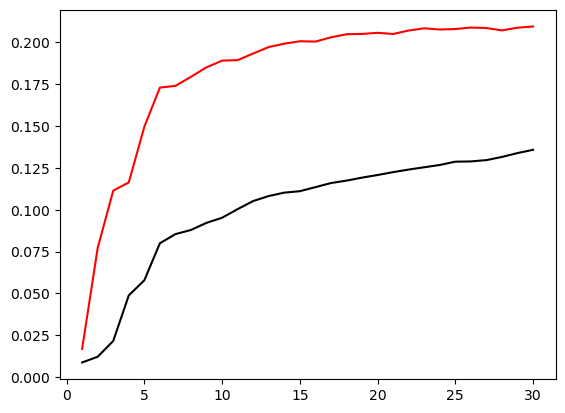

In [27]:
# Plotthe mean r2 averaged over the fold axis for both PCA and LQGCA:
r2_mean = np.mean(r2, axis=2)
r2_std = np.std(r2, axis=2)
fig, ax = plt.subplots()
ax.plot(dims, np.mean(r2_mean[:, :, 0, 1], axis=0), 'k')
ax.plot(dims, np.mean(r2_mean[:, :, 1, 1], axis=0), 'r')

In [28]:
# Basic question: Does the decorrelation actually matter? 
data_files = glob.glob('/mnt/Secondary/data/sabes/indy*')
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

data_files.extend(['/mnt/Secondary/data/sabes/%s' % f for f in good_loco_files])

In [31]:
from decoders import lr_preprocess
from sklearn.metrics import r2_score

In [32]:
# Load each file and determine the r^2 of prediction of residuals
vel_r2 = np.zeros(len(data_files))
acc_r2 = np.zeros(len(data_files))

vel_delta_norm = np.zeros(len(data_files), dtype=np.object)
acc_delta_norm = np.zeros(len(data_files), dtype=np.object)

for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes(data_file)
    X = dat['spike_rates'].squeeze()
    Z = dat['behavior']
    # Do an arbitrary train test split
    decoding_window = 5    
    trainlag = 4
    testlag =4 
    Xtrain = X[X.shape[0]//2:, :]
    Xtest = X[:X.shape[0]//2, :]
    Ztrain = Z[Z.shape[0]//2:, :]
    Ztest = Z[:Z.shape[0]//2, :]

    Xtest, Xtrain, Ztest, Ztrain = lr_preprocess(Xtest, Xtrain, Ztest, Ztrain, trainlag, testlag, 
                                                decoding_window, include_velocity=True, include_acc=True)
    posdecodingregressor = LinearRegression(fit_intercept=True)
    # No train test split here
    pos = np.vstack([Ztrain[:, 0:2], Ztest[:, 0:2]])
    vel = np.vstack([Ztrain[:, 2:4], Ztest[:, 2:4]])
    acc = np.vstack([Ztrain[:, 4:], Ztest[:, 4:]])
    pos_vel = np.hstack([pos, vel])
    posdecodingregressor.fit(pos, vel)

    # Extract the residuals
    vel_pred = posdecodingregressor.predict(pos)
    vel_r2[i] = r2_score(vel, vel_pred)
    vel_delta_norm[i] = np.divide(np.linalg.norm(vel - vel_pred, axis=1), np.linalg.norm(vel, axis=1))

    posveldecodingregressor = LinearRegression(fit_intercept=True)
    posveldecodingregressor.fit(pos_vel, acc)
    # Extract the residuals
    acc_pred = posveldecodingregressor.predict(pos_vel)
    acc_r2[i] = r2_score(acc, acc_pred)
    acc_delta_norm[i] = np.divide(np.linalg.norm(acc - acc_pred, axis=1), np.linalg.norm(acc, axis=1))

/tmp/ipykernel_13266/1473752754.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vel_delta_norm = np.zeros(len(data_files), dtype=np.object)
/tmp/ipykernel_13266/1473752754.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc_delta_norm = np.zeros(len(data_files), dtype=np.object)
13it [01:28,  3.79s/it]/tmp/ipykernel_13266/1473752754.py:34: RuntimeWarning: divide by zero encountered in divide
  vel_delta_norm[i] = np.divide(np.linalg.norm(vel - vel_pred, axis=1), np.

In [34]:
acc_r2

array([0.12935837, 0.09606263, 0.08346429, 0.10158464, 0.10741596,
       0.11338718, 0.11961908, 0.1316327 , 0.11856684, 0.11967178,
       0.12852341, 0.11678613, 0.11917266, 0.10677653, 0.11624808,
       0.11298163, 0.12881971, 0.12964974, 0.12937027, 0.10586292,
       0.10700615, 0.13041494, 0.13563226, 0.12734664, 0.12447797,
       0.11799023, 0.12518533, 0.11962977, 0.07815546, 0.08330095,
       0.07981364, 0.08738562, 0.10461062, 0.09442661, 0.08045028])

In [ ]:
# Load each data file and determine the r^2 prediction of residuals for reach segmented data

In [ ]:
# Load each data file and determine the r^2 prediction of residuals for windowed, reach segmented data